In [1]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime

from pandas.tseries.offsets import *

## Load all data and do pre-processing

In [2]:
filenames = [ 'raw-data/covis-nas1.txt', \
        'raw-data/covis-nas3.txt', \
        'raw-data/covis-nas6.txt' ]

fsz = [pd.read_csv(f, delim_whitespace=True, header=None, names=['nas','bytes','filename']) for f in filenames]
files = pd.concat(fsz)

print("Total of %f TiB" % (files['bytes'].sum() / 2**40))

ts = pd.DataFrame()
split = files['filename'].str.extract('[\.\/a-zA-Z0-9]*_([0-9T]*)\.[0-9Z\-]*([A-Z]*)', expand=True)

files['datetime'] = pd.to_datetime(split[0], format='%Y%m%dT%H%M%S')
files['datatype'] = split[1]

datatypes = files['datatype'].drop_duplicates().values

before = files.shape[0]
files = files.drop_duplicates(subset='datetime')
print("Dropped %d duplicates" % (before-files.shape[0]) )


## Reindex on datatype and date
files.set_index(['datatype','datetime'], inplace=True)
print(files)


Total of 17.708135 TiB
Dropped 17 duplicates
                              nas       bytes  \
datatype datetime                               
DOPPLER  2011-10-01 09:35:33    1  1625146616   
DIFFUSE  2011-10-01 12:59:23    1     3224599   
         2011-10-01 18:59:31    1     3231845   
DOPPLER  2011-10-01 15:35:34    1  1587003908   
         2011-10-01 12:11:52    1  1581885971   
IMAGING  2011-10-01 18:04:30    1   160634205   
DOPPLER  2011-10-01 21:11:37    1  1614996135   
         2011-10-01 18:35:56    1  1609607342   
DIFFUSE  2011-10-01 01:00:00    1     3140924   
DOPPLER  2011-10-01 06:35:50    1  1637845830   
IMAGING  2011-10-01 21:07:57    1   163650038   
DIFFUSE  2011-10-01 21:59:09    1     3199800   
IMAGING  2011-10-01 06:00:39    1   159311472   
         2011-10-01 03:00:39    1   158660859   
         2011-10-01 09:07:56    1   164401747   
         2011-10-01 00:08:40    1   157726854   
         2011-10-01 12:08:15    1   158609330   
         2011-10-01 03:0

In [3]:
## For each datatype, collect into days
files['count'] = 1
byday = files.groupby(level=0).apply(lambda x: x.groupby(pd.Grouper(freq='D',level=1)).sum() )
byday.drop('nas', axis=1, inplace=True)

print(byday)

                            bytes  count
datatype datetime                       
DIFFUSE  2011-09-28  2.499177e+07    8.0
         2011-09-29  2.566892e+07    8.0
         2011-09-30  2.507902e+07    8.0
         2011-10-01  2.543424e+07    8.0
         2011-10-02  2.553987e+07    8.0
         2011-10-03  2.553685e+07    8.0
         2011-10-04  2.539754e+07    8.0
         2011-10-05  2.549140e+07    8.0
         2011-10-06  2.548177e+07    8.0
         2011-10-07  2.557170e+07    8.0
         2011-10-08  2.565856e+07    8.0
         2011-10-09  2.569450e+07    8.0
         2011-10-10  2.561548e+07    8.0
         2011-10-11  2.573374e+07    8.0
         2011-10-12  2.574442e+07    8.0
         2011-10-13  2.579521e+07    8.0
         2011-10-14  2.557286e+07    8.0
         2011-10-15  2.552215e+07    8.0
         2011-10-16  2.570812e+07    8.0
         2011-10-17  2.564597e+07    8.0
         2011-10-18  2.589750e+07    8.0
         2011-10-19  2.588366e+07    8.0
         2011-10

Type = DIFFUSE
Mean = 2492544.556027 bytes, stddev = 369172.975916 bytes
     = 2.377076 MiB, 0.352071 MiB


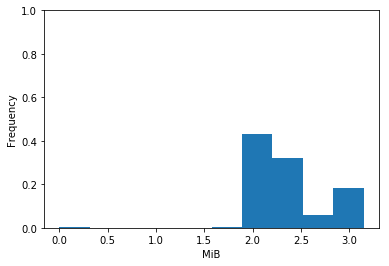

Type = DIFFUSESLOW
Mean = 234270023.000000 bytes, stddev = 636577.462541 bytes
     = 223.417304 MiB, 0.607088 MiB


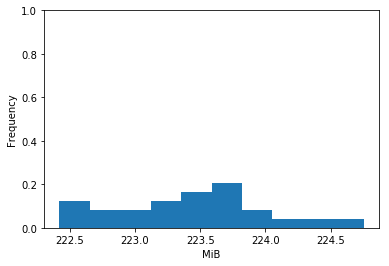

Type = DOPPLER
Mean = 3113799331.862950 bytes, stddev = 513403401.336668 bytes
     = 2969.550449 MiB, 489.619638 MiB


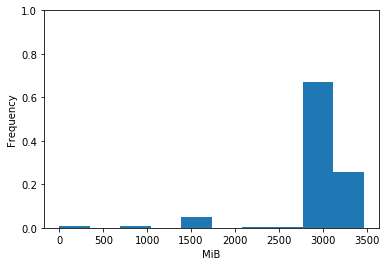

Type = IMAGING
Mean = 473858391.683942 bytes, stddev = 107624045.687865 bytes
     = 451.906578 MiB, 102.638288 MiB


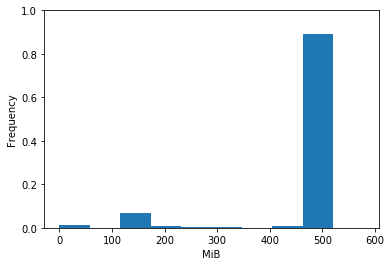

""


In [4]:

def plot_distribution( data ):
    print("Type = %s" % data.index.get_level_values(0).unique()[0])
        
    mean_size = data['bytes'].mean()
    std_size = data['bytes'].std()
    print("Mean = %f bytes, stddev = %f bytes" % (mean_size, std_size) )
    print("     = %f MiB, %f MiB" % (mean_size / 2**20, std_size / 2**20))

    plt.figure()
    weights = np.ones_like(data['bytes'])/float(len(data['bytes']))
    plt.hist( data['bytes']/2**20,normed=False, weights=weights)
    plt.ylim(0.0,1.0)
    plt.ylabel('Frequency')
    plt.xlabel('MiB')
    plt.show()
    
    
files.groupby(level=0).apply(plot_distribution)



In [44]:
## Unstack and resample to bymonth

bymonth = byday.unstack(level=0).resample('M').sum()

#nn =  bymonth.notnull().any(axis=1,bool_only=True)

## Any row which isn't all NA
bymonth = bymonth.dropna(how='all')
    
# Manual
bymonth['bytes','DIFFUSESLOW'][0] = 0
bymonth['count','DIFFUSESLOW'][0] = 0

bymonth.fillna(method='ffill',inplace=True)

bymonth['bytes','total'] = bymonth['bytes'].sum(1)
bymonth['count','total'] = bymonth['count'].sum(1)

## Resample to bring back the NaN
bymonth = bymonth.resample('M').sum()

cumulative = bymonth.cumsum()

print(cumulative)


                   bytes                                              count  \
datatype         DIFFUSE   DIFFUSESLOW       DOPPLER       IMAGING  DIFFUSE   
datetime                                                                      
2011-09-30  7.573972e+07  0.000000e+00  7.740288e+10  1.161155e+10     24.0   
2011-10-31  8.510793e+08  0.000000e+00  8.470713e+11  1.321884e+11    266.0   
2011-11-30  1.250738e+09  0.000000e+00  1.162839e+12  1.960726e+11    391.0   
2011-12-31  2.025001e+09  0.000000e+00  1.493037e+12  3.210774e+11    636.0   
2012-01-31  2.755058e+09  0.000000e+00  2.138055e+12  4.172772e+11    883.0   
2012-02-29  3.429462e+09  0.000000e+00  2.787865e+12  5.094770e+11   1097.0   
2012-03-31  4.212051e+09  0.000000e+00  3.583124e+12  6.351006e+11   1343.0   
2012-04-30  4.972652e+09  0.000000e+00  4.362757e+12  7.576406e+11   1583.0   
2012-05-31  5.623598e+09  0.000000e+00  5.036890e+12  8.633268e+11   1793.0   
2012-06-30  6.363031e+09  0.000000e+00  5.798466e+12

datatype     DIFFUSE  DIFFUSESLOW    DOPPLER    IMAGING
datetime                                               
2011-09-30  0.000069     0.000069   0.070466   0.081027
2011-10-31  0.000774     0.000774   0.771181   0.891406
2011-11-30  0.001138     0.001138   1.058734   1.237061
2011-12-31  0.001842     0.001842   1.359751   1.651770
2012-01-31  0.002506     0.002506   1.947055   2.326567
2012-02-29  0.003119     0.003119   2.538668   3.002034
2012-03-31  0.003831     0.003831   3.262663   3.840284
2012-04-30  0.004523     0.004523   3.972427   4.661497
2012-05-31  0.005115     0.005115   4.586139   5.371330
2012-06-30  0.005787     0.005787   5.279461   6.174814
2012-07-31  0.006488     0.006488   6.005417   7.014163
2012-08-31  0.007185     0.007185   6.735075   7.857955
2012-09-30  0.007849     0.007849   7.440245   8.673791
2012-10-31  0.008494     0.008494   8.122292   9.462486
2012-11-30  0.009045     0.009045   8.718161  10.151500
2012-12-31  0.009717     0.009717   9.445029  10

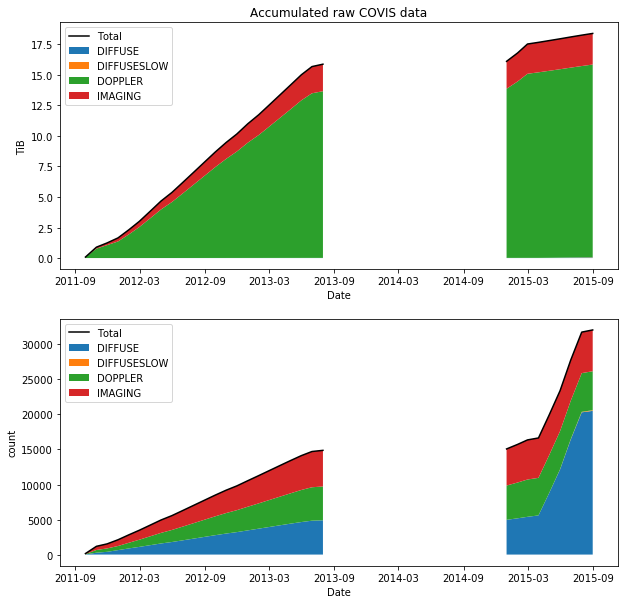

In [46]:
## Plot cumulative values

plt.figure()
# Create a figure with a single subplot
f, ax = plt.subplots(2, figsize=(10,10))

## Make a copy in TiB
cumu = cumulative.copy()
cumu['bytes'] /= 2**40

for i,key in enumerate(['bytes','count']):
    
    rowsum = cumu[key].drop('total',axis=1).cumsum(1) 

    
    cols = rowsum.columns.values
    
    ax[i].fill_between(rowsum.index, 0, rowsum[ cols[0] ], label=cols[0])
        
    for j in range(1, len(cols)):
        print(cols[j])
        ax[i].fill_between(rowsum.index, rowsum[ cols[j-1] ], rowsum[ cols[j] ], label=cols[j])
        

    ax[i].plot(cumu[key].index, cumu[key,'total'],color='k',label='Total')
    ax[i].set_xlabel('Date')
    if i == 0:
        ax[i].set_ylabel('TiB')
        ax[i].set_title('Accumulated raw COVIS data')
    else:
        ax[i].set_ylabel('count')
        
    ax[i].legend()

plt.show()

In [26]:
from datetime import datetime

## Pull out subset for linear regression
subset = bymonth[ datetime(2012,1,1):datetime(2013,6,1) ].copy()
subset['dt'] = (subset.index - subset.index[0]).days

lm = np.polyfit( subset.dt, subset.total, 1 )
print(lm)
slope = np.asscalar(lm[0]) * 2**10  # In gb/day

print("Growth rate %f GiB / day" % (slope))


[ 0.02603229  2.27883494]
Growth rate 26.657062 GiB / day


In [34]:
mission_duration = pd.Timedelta(4 * 365)

rng = pd.date_range('7/1/2018', '7/1/2022', freq='M')
data_volume = pd.DataFrame(index=rng)
data_volume['dt'] = data_volume.index - data_volume.index.min()
data_volume['gibytes'] = data_volume['dt'].apply(lambda x: x.days) * slope
data_volume['tibytes'] = data_volume['gibytes'] / 2**10

print(data_volume)

                  dt       gibytes    tibytes
2018-07-31    0 days      0.000000   0.000000
2018-08-31   31 days    826.368922   0.807001
2018-09-30   61 days   1626.080781   1.587970
2018-10-31   92 days   2452.449703   2.394970
2018-11-30  122 days   3252.161562   3.175939
2018-12-31  153 days   4078.530484   3.982940
2019-01-31  184 days   4904.899405   4.789941
2019-02-28  212 days   5651.297141   5.518845
2019-03-31  243 days   6477.666062   6.325846
2019-04-30  273 days   7277.377922   7.106814
2019-05-31  304 days   8103.746844   7.913815
2019-06-30  334 days   8903.458703   8.694784
2019-07-31  365 days   9729.827625   9.501785
2019-08-31  396 days  10556.196546  10.308786
2019-09-30  426 days  11355.908406  11.089754
2019-10-31  457 days  12182.277327  11.896755
2019-11-30  487 days  12981.989187  12.677724
2019-12-31  518 days  13808.358108  13.484725
2020-01-31  549 days  14634.727030  14.291726
2020-02-29  578 days  15407.781828  15.046662
2020-03-31  609 days  16234.150749